In [1]:
GPU_NUM = 4

# 3. Model Evaluation

##### This notebook demonstrates the evaluation of our trained model across two distinct datasets. We'll assess its performance using

##### 1. Internal test data: This is derived from the same source as our training data (**Data1**).
##### 2. External test data: We'll use an independent dataset (**Data3**) to gauge the model's generalization capabilities.

##### By comparing results from both internal and external tests, we can gain insights into the model's robustness and its ability to handle diverse data.

## 3.1. Import essential libraries and evironment setting 

In [4]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 74.4 MB/s eta 0:00:00:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
from glob import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

2024-08-20 15:55:37.109273: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 15:55:37.135867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 15:55:37.168471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 15:55:37.177580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 15:55:37.205708: I tensorflow/core/platform/cpu_feature_guar

In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_NUM)

## 3.2. Load the best model from 'Model_training' 

In [14]:
# model = load_model('./weights/best_model_Data1.keras')

# Load the following model trained by us if you haven't had your own model yet.
model = load_model('/fsx/embed/summer-school-24/Datathon24_SummerSchool_CXR/weights/best_model_Data1.keras')

## 3.3. Load and process testing images

In [15]:
# Define a function for image preprocessing 
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

# Load and preprocess test images

positive_paths = glob('/fsx/embed/summer-school-24/Datathon24_SummerSchool_CXR/Data1_Preprocessed/test/positive/*.png')
negative_paths = glob('/fsx/embed/summer-school-24/Datathon24_SummerSchool_CXR/Data1_Preprocessed/test/negative/*.png')

#positive_paths = glob('/home/fli40/Data/Datathon24_SummerSchool_CXR/Data1_Preprocessed/test/positive/*.png')
#negative_paths = glob('/home/fli40/Data/Datathon24_SummerSchool_CXR/Data1_Preprocessed/test/negative/*.png')

test_image_paths = positive_paths + negative_paths  # Add all test image paths
test_labels = [1]*len(positive_paths) + [0]*len(negative_paths)  # Add corresponding true labels (0 or 1 for binary classification)

X_test = np.vstack([load_and_preprocess_image(img_path) for img_path in test_image_paths])
y_true = np.array(test_labels)

### 2.3.1. Show some testing data 

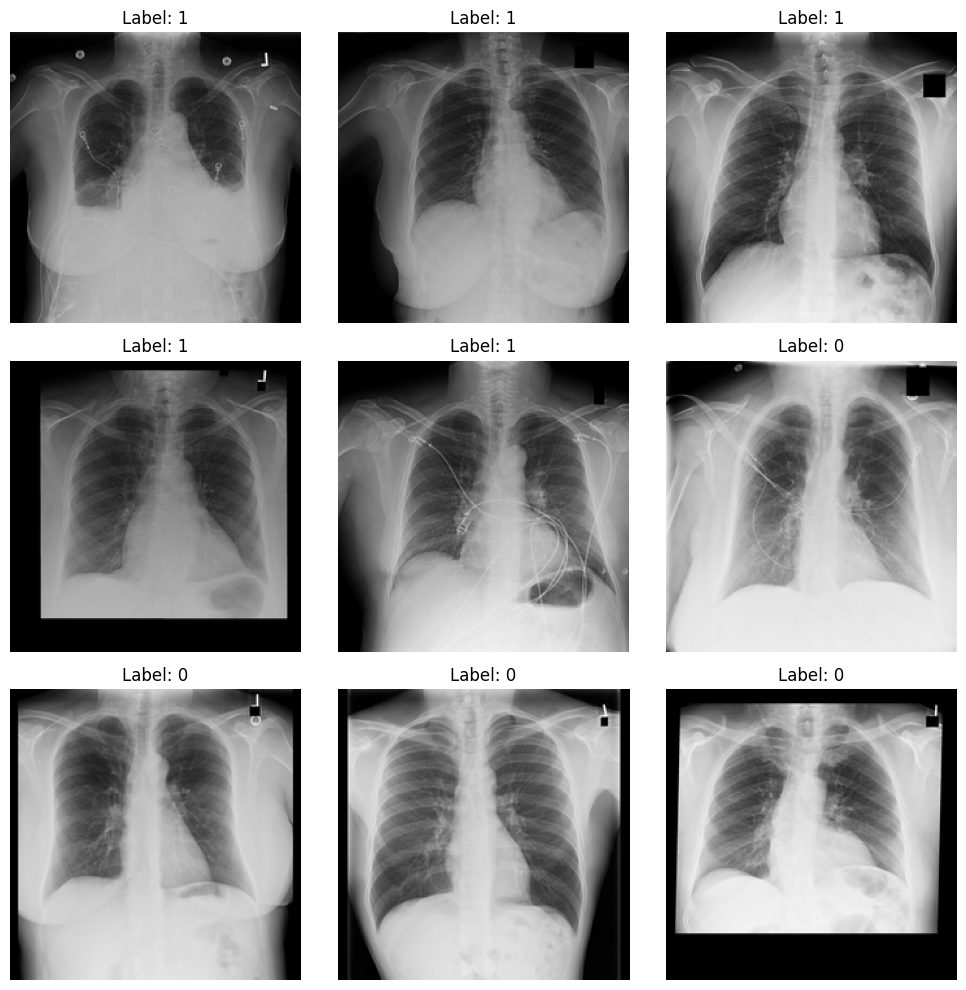

In [16]:
plt.figure(figsize=(10, 10))

for i in range(min(len(X_test), 9)):  # Display up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow((X_test[i*50]*255).astype("uint8"))
    plt.title(f"Label: {y_true[i*50]}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## 3.4. Make predictions
The model is predicting whether each instance belongs to one of two classes (e.g., "yes" or "no", "positive" or "negative"). 


### 3.4.1. Output probability

The output, y_pred_prob, contains predicted probabilities that each instance in X_test belongs to the positive class (class 1).
##### 💡 Example: If the model predicts a 0.7 probability for an instance, it suggests there's a 70% chance that the instance belongs to the positive class.

In [17]:
y_pred_prob = model.predict(X_test)

I0000 00:00:1724169883.160952   90911 service.cc:146] XLA service 0x718540279dc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724169883.161047   90911 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-08-20 16:04:43.346813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1724169886.128876   90911 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 964ms/step


### 3.4.2. Output binary label
This line converts the predicted probabilities into binary class predictions (0 or 1).
##### 💡 Example: If y_pred_prob for an instance is 0.7, y_pred for that instance will be 1 because 0.7 > 0.5. If y_pred_prob is 0.3, y_pred will be 0.

In [18]:
y_pred = (y_pred_prob > 0.5).astype(int)  # Assuming 0.5 as threshold for binary classification

In [19]:
# Save evaluation results as csv
df_results = pd.DataFrame(test_image_paths, columns=['Path'])
df_results['Label'] = y_true
df_results['Prediction'] = y_pred
df_results['Probability'] = y_pred_prob
df_results.to_csv('./results/Model1_TestSet.csv', index=False)
df_results

Path  Label  Prediction  \
0    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           1   
1    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           0   
2    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           1   
3    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           0   
4    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           1   
..                                                 ...    ...         ...   
446  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           1   
447  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           1   
448  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           1   
449  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           1   
450  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           0   

     Probability  
0       0.973679  
1       0.253924  
2       0.924028  
3       0.276222  
4       0.940456  
..           ...  
446     0.673729  
447     0.693287  
448     0.635420  
449     0.662531  
450     0.368504  

[451 rows x 4 columns]

### 3.4.3. Show some testing results

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


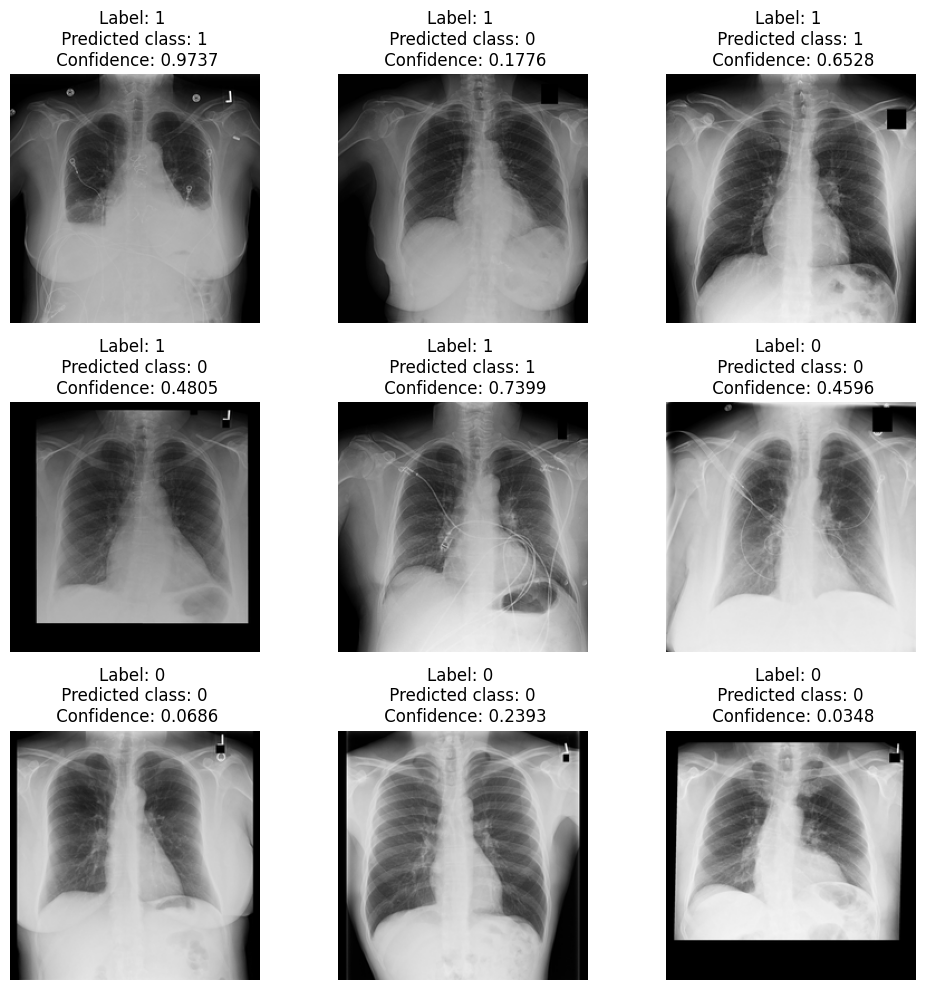

In [20]:
plt.figure(figsize=(10, 10))

for i in range(min(len(X_test), 9)):  # Display up to 9 images
    prediction = model.predict(X_test[i*50:i*50+1,:,:,:])[0][0]
    predicted_class = 1 if prediction > 0.5 else 0
    plt.subplot(3, 3, i + 1)
    plt.imshow((X_test[i*50]*255).astype("uint8"))
    plt.title(f"Label: {y_true[i*50]} \n Predicted class: {predicted_class} \n Confidence: {prediction:.4f}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## 3.5. Evaluate model with metrics

### 3.5.1. Confusion matrix

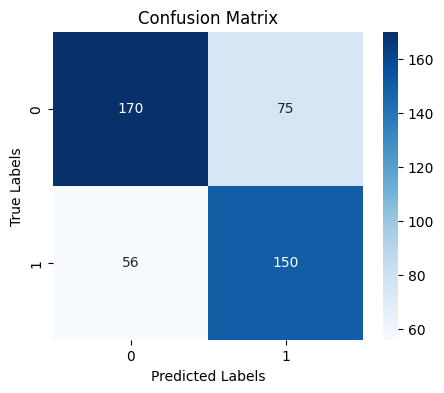

In [21]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 3.5.2. Model Evaluation Metrics

To comprehensively assess our model's performance, we employ a diverse set of evaluation metrics:

#### 1. Accuracy
- The proportion of correct predictions (both true positives and true negatives) among the total number of cases examined.
- **Formula:** $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
  
  Where:
  - TP = True Positives
  - TN = True Negatives
  - FP = False Positives
  - FN = False Negatives

#### 2. Sensitivity, also known as Recall
- The proportion of actual positive cases that were correctly identified.
- **Formula:** $Sensitivity = \frac{TP}{TP + FN}$

#### 3. Specificity
- The proportion of actual negative cases that were correctly identified.
- **Formula:** $Specificity = \frac{TN}{TN + FP}$

#### 4. PPV (Positive Predictive Value), also known as Precision
- The proportion of positive identifications that are actually correct.
- **Formula:** $PPV = \frac{TP}{TP + FP}$

#### 5. F1 Score
- The harmonic mean of precision and recall, providing a balanced measure of the model's accuracy.
- **Formula:** $F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$

#### 6. AUC (Area Under the ROC Curve)
- Measures the model's ability to distinguish between classes across all classification thresholds.
- AUC is calculated by plotting the True Positive Rate against the False Positive Rate at various threshold settings.

<img src="files/class_score.png" alt="Drawing" style="height: 400px;"/>

Ref: https://permetrics.readthedocs.io/en/latest/pages/classification/F1S.html

In [22]:
# Calculate metrics
auc_1 = roc_auc_score(y_true, y_pred_prob)
f1_1 = f1_score(y_true, y_pred)
accuracy_1 = accuracy_score(y_true, y_pred)
ppv_1 = precision_score(y_true, y_pred)  # PPV is the same as precision
sensitivity_1 = recall_score(y_true, y_pred)  # Sensitivity is the same as recall
specificity_1 = recall_score(y_true, y_pred, pos_label=0)  # Specificity is recall of the negative class

# Print results
print(f"AUC: {auc_1:.4f}")
print(f"F1 Score: {f1_1:.4f}")
print(f"Accuracy: {accuracy_1:.4f}")
print(f"PPV (Precision): {ppv_1:.4f}")
print(f"Sensitivity (Recall): {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")

AUC: 0.8022
F1 Score: 0.6961
Accuracy: 0.7095
PPV (Precision): 0.6667
Sensitivity (Recall): 0.7282
Specificity: 0.6939


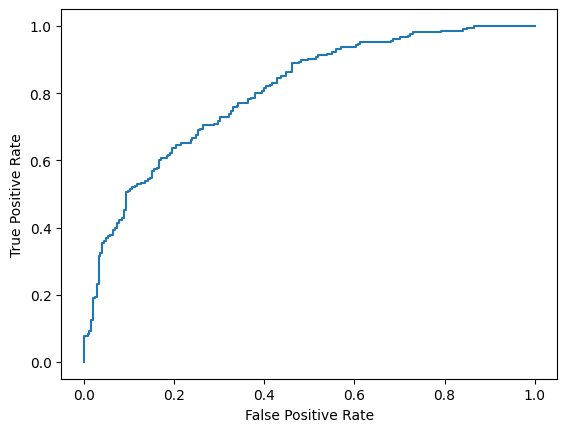

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob) 
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## 3.6. External Validation
We then use Data3 as external dataset for validation

In [24]:
# Load and preprocess test images

positive_paths = glob('/fsx/embed/summer-school-24/Datathon24_SummerSchool_CXR/Data3_Preprocessed/positive/*.png')
negative_paths = glob('/fsx/embed/summer-school-24/Datathon24_SummerSchool_CXR/Data3_Preprocessed/negative/*.png')

#positive_paths = glob('/home/fli40/Data/Datathon24_SummerSchool_CXR/Data3_Preprocessed/positive/*.png')
#negative_paths = glob('/home/fli40/Data/Datathon24_SummerSchool_CXR/Data3_Preprocessed/negative/*.png')

test_image_paths = positive_paths + negative_paths  # Add all test image paths
test_labels = [1]*len(positive_paths) + [0]*len(negative_paths)  # Add corresponding true labels (0 or 1 for binary classification)

X_test = np.vstack([load_and_preprocess_image(img_path) for img_path in test_image_paths])
y_true = np.array(test_labels)

In [25]:
# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Assuming 0.5 as threshold for binary classification

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 678ms/step


In [26]:
# Save evaluation results as csv
df_results = pd.DataFrame(test_image_paths, columns=['Path'])
df_results['Label'] = y_true
df_results['Prediction'] = y_pred
df_results['Probability'] = y_pred_prob
df_results.to_csv('./results/Model1_External.csv', index=False)
df_results

Path  Label  Prediction  \
0    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           1   
1    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           0   
2    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           1   
3    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           1   
4    /fsx/embed/summer-school-24/Datathon24_SummerS...      1           1   
..                                                 ...    ...         ...   
548  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           0   
549  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           1   
550  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           0   
551  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           1   
552  /fsx/embed/summer-school-24/Datathon24_SummerS...      0           0   

     Probability  
0       0.541717  
1       0.199344  
2       0.911960  
3       0.526672  
4       0.544410  
..           ...  
548     0.023802  
549     0.534675  
550     0.125454  
551     0.678256  
552     0.163849  

[553 rows x 4 columns]

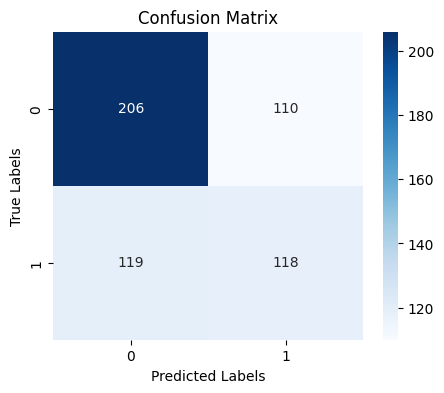

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
# Calculate metrics
auc_3 = roc_auc_score(y_true, y_pred_prob)
f1_3 = f1_score(y_true, y_pred)
accuracy_3 = accuracy_score(y_true, y_pred)
ppv_3 = precision_score(y_true, y_pred)  # PPV is the same as precision
sensitivity_3 = recall_score(y_true, y_pred)  # Sensitivity is the same as recall
specificity_3 = recall_score(y_true, y_pred, pos_label=0)  # Specificity is recall of the negative class

# Print results
print(f"AUC: {auc_3:.4f}")
print(f"F1 Score: {f1_3:.4f}")
print(f"Accuracy: {accuracy_3:.4f}")
print(f"PPV (Precision): {ppv_3:.4f}")
print(f"Sensitivity (Recall): {sensitivity_3:.4f}")
print(f"Specificity: {specificity_3:.4f}")

AUC: 0.6128
F1 Score: 0.5075
Accuracy: 0.5859
PPV (Precision): 0.5175
Sensitivity (Recall): 0.4979
Specificity: 0.6519


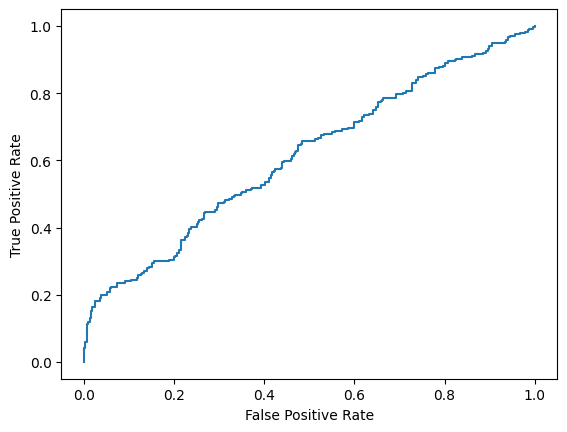

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob) 
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## 3.7. Comparison

In [30]:
data = [["AUC",auc_1, auc_3], ["F1 Score",f1_1, f1_3], ["Accuracy",accuracy_1, accuracy_3], ["PPV",ppv_1, ppv_3], ["Sensitivity",sensitivity_1, sensitivity_3], ["Specificity",specificity_1, specificity_3]]
pd.DataFrame(data, columns=["Metrics", "Data1", "Data3"])

Metrics     Data1     Data3
0          AUC  0.802180  0.612842
1     F1 Score  0.696056  0.507527
2     Accuracy  0.709534  0.585895
3          PPV  0.666667  0.517544
4  Sensitivity  0.728155  0.497890
5  Specificity  0.693878  0.651899

## Observed that model performed worse on DATA3

In [31]:
# Define function for plotting images
def plot_images(images, title, n_rows=3, n_cols=3):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [32]:
# Get tp, fp, tn, fn samples for visualization
false_negatives = df_results[(df_results.Label == 1) & (df_results.Prediction==0)].sample(9)
true_positives = df_results[(df_results.Label == 1) & (df_results.Prediction==1)].sample(9)
false_positives = df_results[(df_results.Label == 0) & (df_results.Prediction==1)].sample(9)
true_negatives = df_results[(df_results.Label == 0) & (df_results.Prediction==0)].sample(9)

fn = np.vstack([load_and_preprocess_image(img_path) for img_path in false_negatives.Path])
tp = np.vstack([load_and_preprocess_image(img_path) for img_path in true_positives.Path])
fp = np.vstack([load_and_preprocess_image(img_path) for img_path in false_positives.Path])
tn = np.vstack([load_and_preprocess_image(img_path) for img_path in true_negatives.Path])

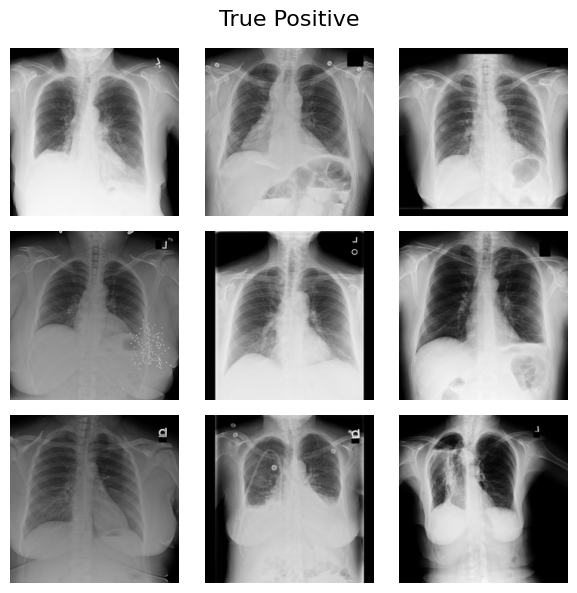

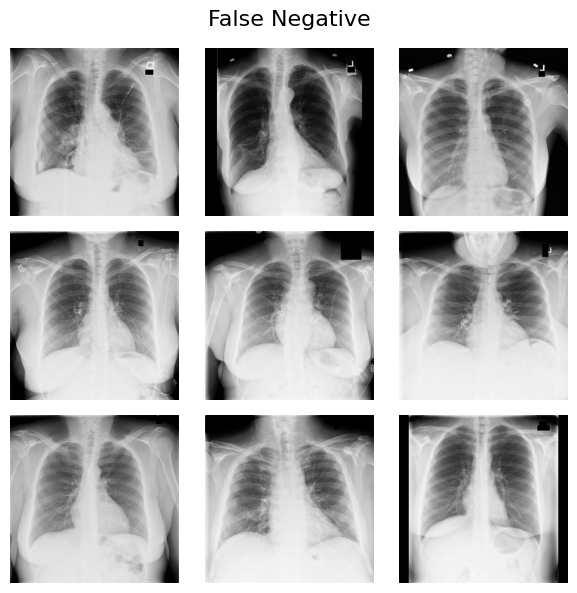

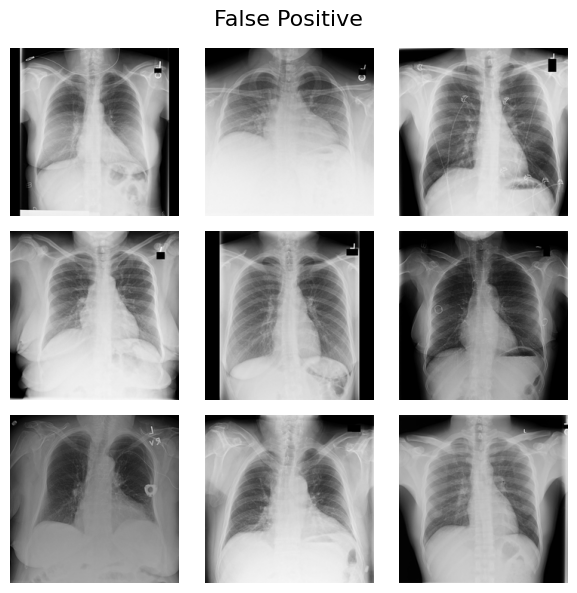

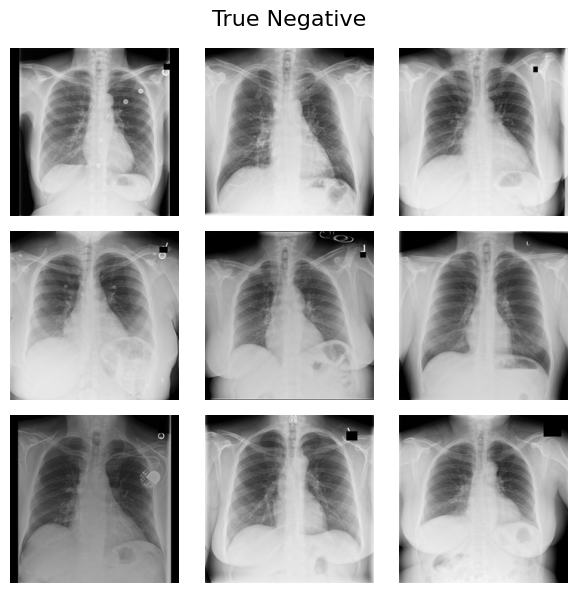

In [33]:
# Plot some true positive samples
plot_images(tp, f"True Positive")

# Plot some false negative samples
plot_images(fn, f"False Negative")

# Plot some false positive samples
plot_images(fp, f"False Positive")

# Plot some true negative samples
plot_images(tn, f"True Negative")

In [34]:
import keras
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):

    img = (img*255).astype("uint8")
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))

    return cam_path

def plot_cams(images, title, n_rows=3, n_cols=3):

    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        heatmap = make_gradcam_heatmap(images[i:i+1,:,:,:], model, last_conv_layer_name)
        p = save_gradcam(images[i,:,:,:], heatmap)
        tp_gradcam = plt.imread(p)
        ax.imshow(tp_gradcam)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [35]:
last_conv_layer_name = "conv5_block3_3_conv"
model.layers[-1].activation = None
heatmap = make_gradcam_heatmap(tp[0:1,:,:,:], model, last_conv_layer_name)

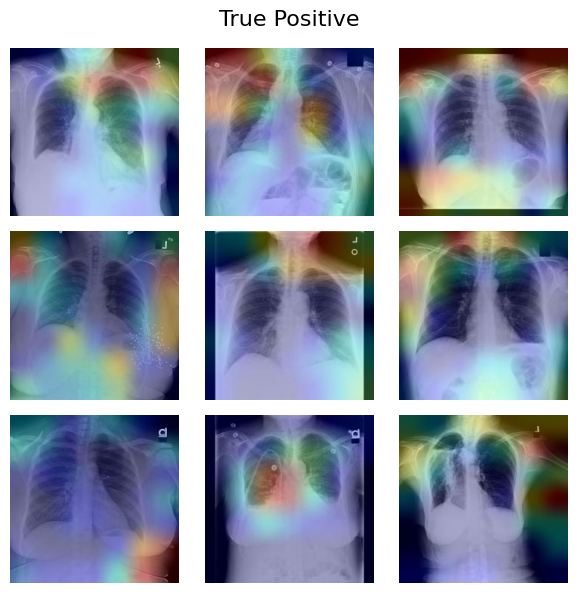

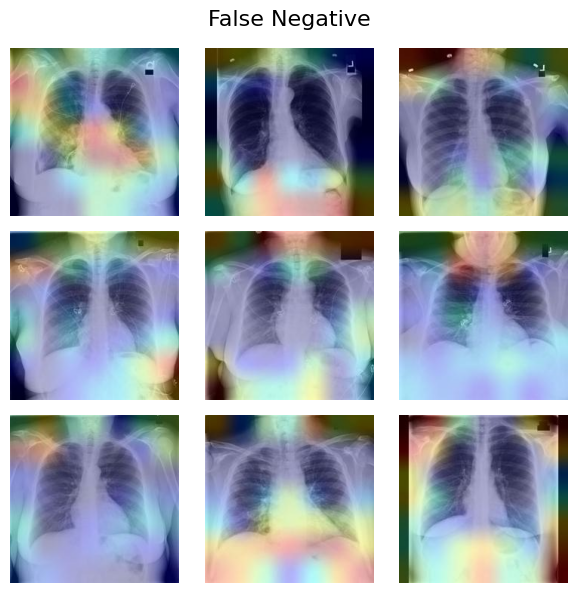

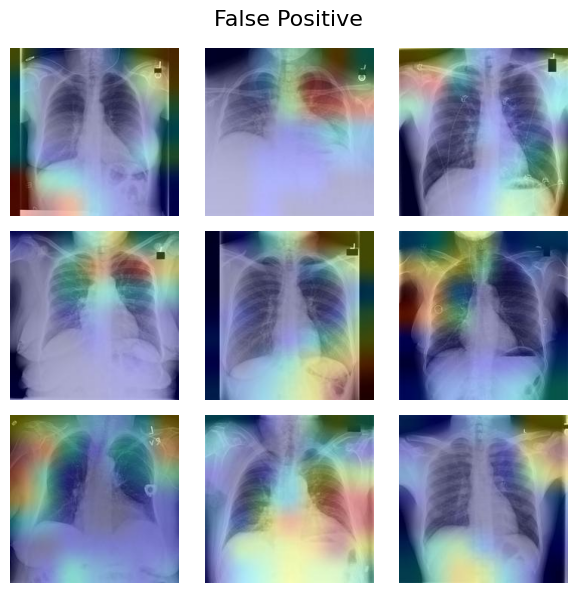

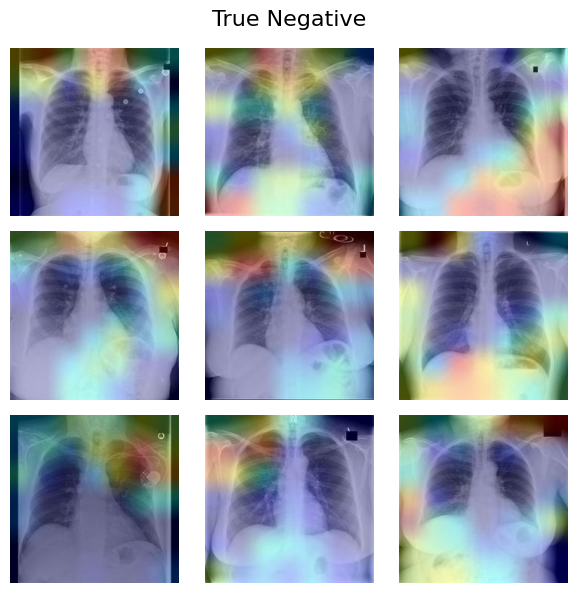

In [36]:
# Plot some true positive samples
plot_cams(tp, f"True Positive")

# Plot some false negative samples
plot_cams(fn, f"False Negative")

# Plot some false positive samples
plot_cams(fp, f"False Positive")

# Plot some true negative samples
plot_cams(tn, f"True Negative")